# **Import necessary libraries**

In [ ]:
# Import necessary libraries for data manipulation
import joblib
import string
import pandas as pd
import numpy as np
from numpy.random import multivariate_normal
# Import necessary libraries for deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
# Import necessary libraries for machine learning
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn import preprocessing
# Import necessary libraries for visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import style
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
style.use('ggplot') or plt.style.use('ggplot')
import seaborn as sns;
from cycler import cycler

def load_permittivitys(df):
  """Assign permittivity values (formula and literature) to the data based on its label."""
  # Mapping for labels to permittivity values. (Left column) Values obtained by mixing rule
  # (Right column) experimental values obtained in the literature
  permittivity_map = {
    'WATER': (78.2998, 78.3),
    'GLY10': (75.5077, 73.32),
    'GLY20': (70.9935, 69.23),
    'GLY30': (64.5400, 65.25),
    'GLY40': (56.2274, 58.78),
    'GLY50': (46.5203, 51.55),
    'GLY60': (36.2432, 39.0),
    'GLY70': (26.4155, 27.45),
    'GLY80': (17.9825, 17.0),
    'AIR':   (1.0,      1.0),
  }
  # Use map to apply permittivity values based on label
  df['formula'] = df['label'].map(lambda x: permittivity_map.get(x, (None, None))[0])
  df['literature'] = df['label'].map(lambda x: permittivity_map.get(x, (None, None))[1])

  return df

# **Loading DR sensor data and defining the VAE Architecture**



In [ ]:
##### VAE ARCHITECTURE #####
average_signals = joblib.load(r'/content/average_signals.pkl') ## Average class signals correspindng to each glycerine concentration
paper_data = joblib.load(r'/content/paper_data.pkl') # Load datasets employed in the article to replicate the results
X_train = paper_data['X_train']
X_val = paper_data['X_val']
y_train = paper_data['y_train']
y_val = paper_data['y_val']
n_columns = paper_data['n_columns']
n_signals = paper_data['n_signals']

##### VAE ARCHITECTURE #####
# Define a custom layer for the sampling step in the Variational Autoencoder (VAE)
class Sampling(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = tf.random.set_seed(1337)
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Dimensionality of the latent space
latent_dim =2

#### ENCODER ####
original_spectrum = keras.Input(shape=[n_columns])
E = layers.BatchNormalization()(original_spectrum)
E = layers.Dense(50, activation="leaky_relu", kernel_initializer='he_normal')(E)
E = layers.BatchNormalization()(E)
E = layers.Dense(50, activation="leaky_relu", kernel_initializer='he_normal')(E)
codings_means=layers.Dense(latent_dim)(E)
codings_log_var=layers.Dense(latent_dim)(E)
codings=Sampling()([codings_means, codings_log_var])
variational_encoder=keras.Model(inputs=original_spectrum,outputs=[codings_means,codings_log_var,codings])
##### DECODER #####
decoder_inputs=keras.Input(shape=[latent_dim])
D = layers.BatchNormalization()(decoder_inputs)
D = layers.Dense(50, activation="leaky_relu", kernel_initializer='he_normal')(D)
D = layers.BatchNormalization()(D)
D = layers.Dense(50, activation="leaky_relu", kernel_initializer='he_normal')(D)
decoder_outputs=layers.Dense(n_columns, activation="linear")(D)
variational_decoder=keras.Model(inputs=[decoder_inputs],outputs=[decoder_outputs])
##### COMPLETE MODEL #####
codings_means,codings_log_var,codings=variational_encoder([original_spectrum])
reconstructions=variational_decoder(codings)
variational_autoencoder=keras.Model(inputs=[original_spectrum],outputs=[reconstructions,codings_means,codings_log_var])

# **Comparison between original and reconstructed signals from the validation dataset for different $\beta$ values**

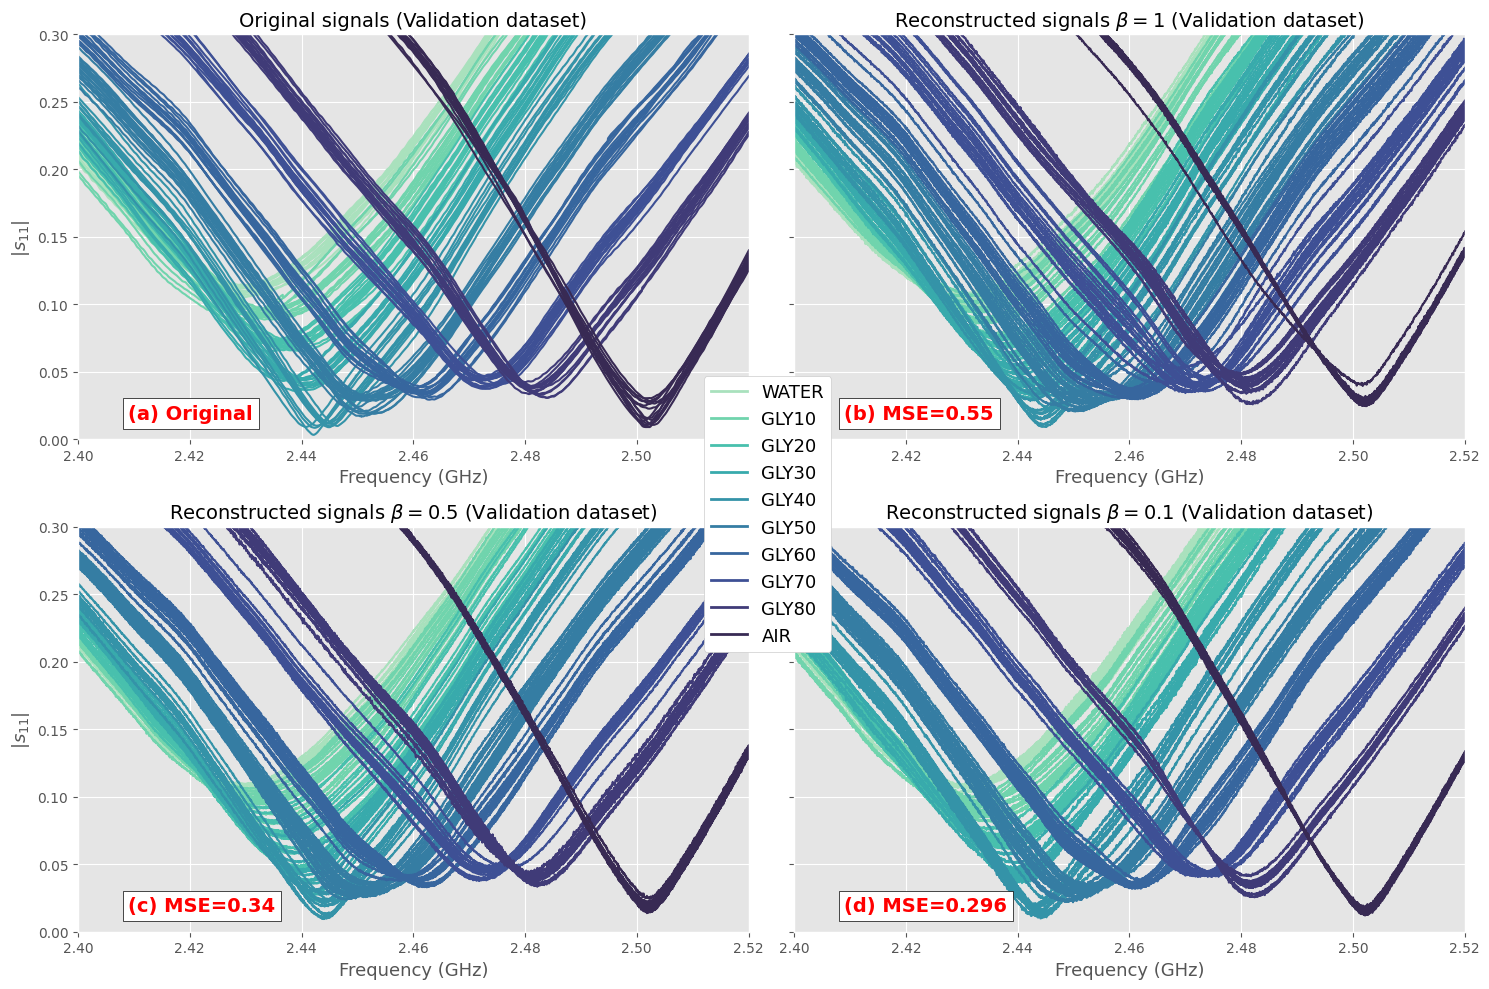

In [ ]:
# Set up categorical labels for plotting
from pandas.api.types import CategoricalDtype
import random
order= ['WATER','GLY10', 'GLY20','GLY30', 'GLY40','GLY50', 'GLY60','GLY70', 'GLY80','AIR']
cat_order = CategoricalDtype(order,ordered=True)
X_plot=X_val.copy()
X_plot['label'] = y_val.astype(cat_order)

# Define a colormap and generate colors for each glycerin concentrations
mako_cmap = sns.color_palette("mako_r", as_cmap=True)
colors = mako_cmap(np.linspace(0.1, 0.8, 10))  # Generate 10 colors from the colormap

beta_values=["beta_1","beta_0.5","beta_0.1"]
# Plot original and reconstructed signals
fig, axs= plt.subplots(2, 2, figsize=(15, 10), sharey=True)
axs = axs.flatten()
# The for loop goes class by class in the established order to keep the color scheme
for ii,cc in zip(order, colors):
    # Original signals plot
    df_ii=X_plot.loc[X_plot['label']==str(ii)].drop(['label'],axis=1).transpose()
    idx=df_ii.index.astype(float) # Convert index to float for frequency axis
    df_ii.index=idx
    df_ii.plot(ax=axs[0], color=cc)

    i=1
    # Reconstructed signals for different beta_values
    for folder in beta_values:
      # Load trained weights for the model
      loaded_weights = joblib.load(f'/content/{folder}/weights_{folder}.pkl')
      # Update model weights
      variational_autoencoder.set_weights(weights=loaded_weights)
      # Generate latent vectors
      codings_means,codings_log_var,lantent_class_vectors=variational_encoder(df_ii.transpose())
      # Recontruct signals
      decoded_signals=variational_decoder(lantent_class_vectors)
      decoded_signals=pd.DataFrame(decoded_signals)
      decoded_signals=decoded_signals.transpose()
      decoded_signals.index=df_ii.index
      decoded_signals.plot(ax=axs[i], color=cc)
      i=i+1

# Add annotations and titles to the plots
j=0
error_values=["(a) Original","(b) MSE=0.55","(c) MSE=0.34","(d) MSE=0.296"]
for j,t in zip(range(4),error_values):
    axs[j].legend([],framealpha=0)
    axs[j].set_xlim(2.4,2.52)
    axs[j].set_ylim(0,0.3)
    axs[j].set_xlabel('Frequency (GHz)', fontsize=13)
    textstr=t
    axs[j].text(2.409, 0.015, textstr, fontsize=14, color='red',fontweight='bold',
        bbox=dict(facecolor='white', alpha=1, edgecolor='black'))
    j=j+1

# Set titles for each subplot
axs[0].set_title(r'Original signals (Validation dataset)', fontsize=14)
axs[1].set_title(r'Reconstructed signals $\beta=1$ (Validation dataset)', fontsize=14)
axs[2].set_title(r'Reconstructed signals $\beta=0.5$ (Validation dataset)', fontsize=14)
axs[3].set_title(r'Reconstructed signals $\beta=0.1$ (Validation dataset)', fontsize=14)
# Add y-axis labels for the leftmost plots
axs[0].set_ylabel("|$s_{11}$|", fontsize=13)
axs[2].set_ylabel("|$s_{11}$|", fontsize=13)

# Define custom legend elements for the shared legend
legend_elements = [
    Line2D([0], [0], color=colors[i], lw=2, label=order[i])
    for i in range(10)
]

# Create a shared legend for all subplots
fig.legend(handles=legend_elements, loc='center', fontsize=13,framealpha=1, frameon=True, facecolor='white',
           bbox_to_anchor=(0.515, 0.48),ncol=1)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# **Averages of the reconstructed signals compared to the original averages.**

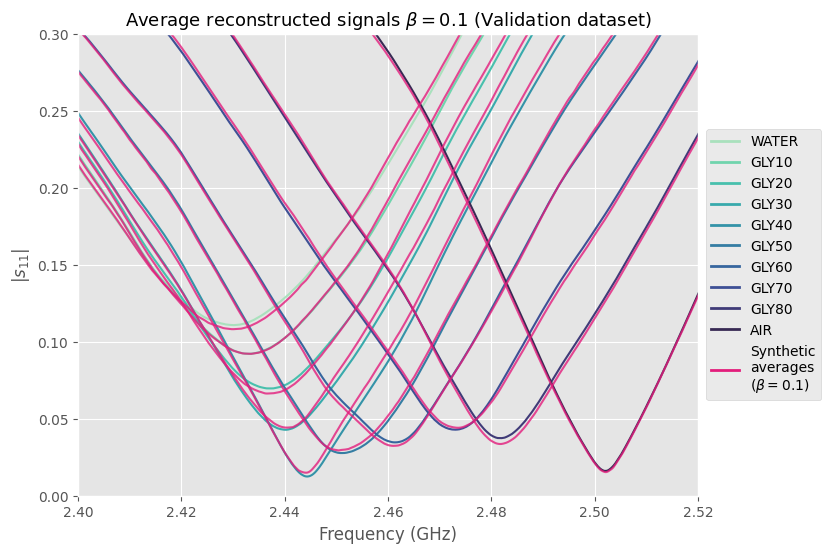

In [ ]:
from scipy.ndimage import gaussian_filter1d  # Import for applying Gaussian smoothing
sigma = 5  # Standard deviation for Gaussian kernel

# Combine validation data and labels into a single DataFrame
df_val_plot = pd.concat([X_val, y_val], axis=1)
df_total = pd.DataFrame()  # Initialize an empty DataFrame to store reconstructed signals
list_labels = list(average_signals.columns)  # Extract labels from average_signals
latent_media_points = []  # List to store latent space averages for each label

# Load pre-trained model weights for beta=0.1
folder="beta_0.1"
loaded_weights = joblib.load(f'/content/{folder}/weights_{folder}.pkl')
variational_autoencoder.set_weights(weights=loaded_weights) # Set weights for the model

# Loop through each label (refering to a glycerin concentration) and process its data
for x in list_labels:
   # Searach in the validation data for the current label
    class_df_val=df_val_plot.loc[df_val_plot['label']==str(x)]
    class_info_val=class_df_val['label'] # Store the labels
    class_df_val=class_df_val.drop(columns='label') # Remove label column for processing

    # Encode the data into latent vectors
    _,_,lantent_class_vectors=variational_encoder(class_df_val)
    average_latent_vector=lantent_class_vectors.numpy().mean(axis=0)
     # Decode the average latent vector back into the signal space
    val_codins=tf.constant([average_latent_vector]) # Convert to a constant tensor
    new_spectrum=variational_decoder(val_codins)
    new_spectrum = gaussian_filter1d(new_spectrum, sigma)  # Apply Gaussian smoothing
    df_total=pd.concat([df_total, pd.DataFrame(new_spectrum)]) # Append reconstructed signal

# Set column names to match the original signals for plotting
df_total.columns=average_signals.transpose().columns

# Generate colormap for plotting
mako_cmap = sns.color_palette("mako_r", as_cmap=True)
colors = mako_cmap(np.linspace(0.1, 0.8, 10))  # Generate 10 colors from the colormap

# Plotting reconstructed signals
fig, ax = plt.subplots(figsize=(8, 6))
for i, column in enumerate(average_signals.columns):
    ax.plot(average_signals.index, average_signals[column], color=colors[i], alpha=1) # Plot original signals

# Configure plot limits and labels
plt.xlim(2.4,2.52)
plt.ylim(0,0.3)
plt.xlabel("Frequency (GHz)")
plt.ylabel("|$s_{11}$|")

# Plot the reconstructed average signals
ax.plot(df_total.transpose(),color='#e31d7c', alpha=0.8)

# Create a custom legend entry for the synthetic averages
custom_line = Line2D([0], [0], color='#e31d7c', lw=2, label='Synthetic\naverages\n($\\beta=0.1$)')
legend_elements = [
    Line2D([0], [0], color=colors[i], lw=2, label=order[i])
    for i in range(10)
]
legend_elements.append(custom_line)  # Add synthetic average entry to legend

# Configure legend and title
ax.legend(handles=legend_elements, loc='right', bbox_to_anchor=(1.21, 0.5))
ax.set_title(r'Average reconstructed signals $\beta=0.1$ (Validation dataset)', fontsize=13)
plt.show()

# **Latent representation of the training dataset for different values of $\beta$**

<ipython-input-5-165100caeb08>:52: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=latent_media_points,x='Latent_1', y='Latent_2', hue='label', ax=axs[i], palette=["#e31d7c"])
<ipython-input-5-165100caeb08>:52: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=latent_media_points,x='Latent_1', y='Latent_2', hue='label', ax=axs[i], palette=["#e31d7c"])
<ipython-input-5-165100caeb08>:52: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=latent_media_points,x='Latent_1', y='Latent_2', hue='label', ax=axs[i], palette=["#e31d7c"])
<ipython-input-5-165100caeb08>:52: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.


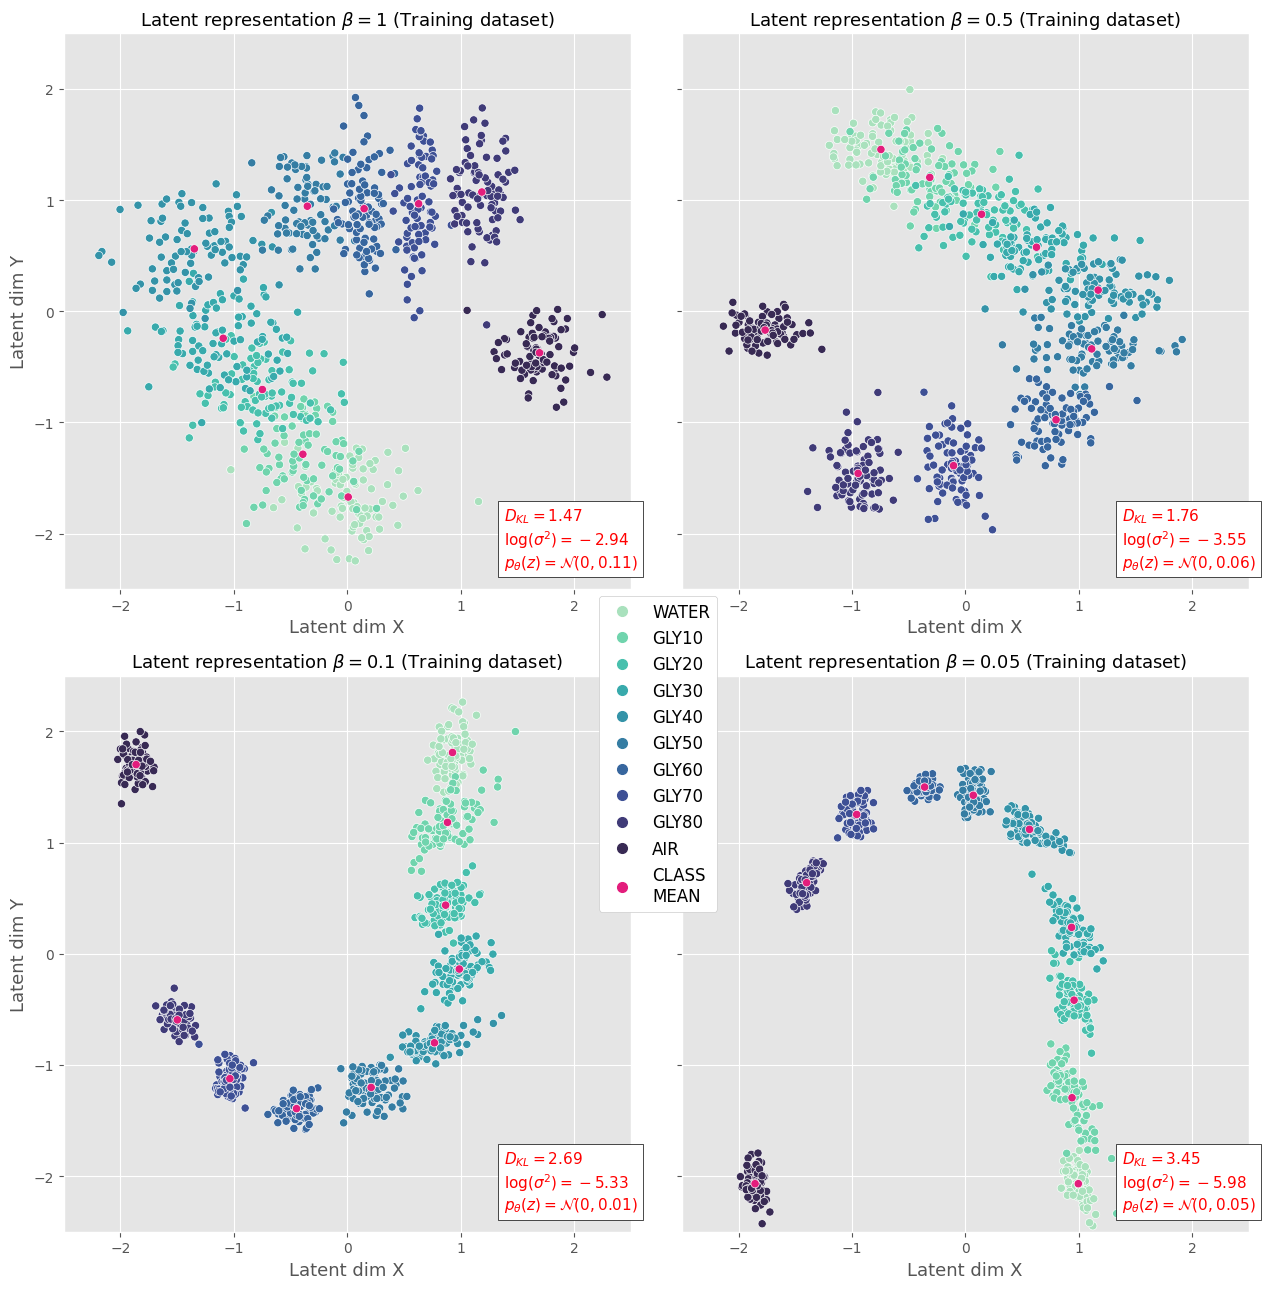

In [ ]:
df_train_latent=pd.concat([X_train,y_train], axis=1)
df_latent_copy=pd.DataFrame()

# Set up a 2x2 grid of subplots
fig, axs= plt.subplots(2, 2, figsize=(13, 13), sharey=True)
axs = axs.flatten() # Flatten to access subplots using a single index

# Create a dictionary mapping class labels to colors for consistent visualization
mako_cmap = sns.color_palette("mako_r", as_cmap=True)
palette = mako_cmap(np.linspace(0.1, 0.8, 10))
palette_dict = {label: palette[i] for i, label in enumerate(order)}

# Iterate over the different beta values to visualize their effects
i=0
beta_values=["beta_1","beta_0.5","beta_0.1","beta_0.05"]
for folder in beta_values:
  # Load pre-trained model weights for the current beta value
  loaded_weights = joblib.load(f'/content/{folder}/weights_{folder}.pkl')
  variational_autoencoder.set_weights(weights=loaded_weights)

  df_latent=pd.DataFrame() # Initialize an empty DataFrame for latent space data
  latent_media_points=[]   # To store the average latent vectors for each class
  # Process each class label
  for ii,cc in zip(order, colors):

    class_df_train=df_train_latent.loc[df_train_latent['label']==str(ii)]
    class_info_train=class_df_train['label']
    class_df_train=class_df_train.drop(columns='label')

    # Encode the training data into latent vectors
    _,_,lantent_class_vectors=variational_encoder(class_df_train)
    new_latent=pd.DataFrame(lantent_class_vectors)

    # Calculate and store the average latent vector for the class
    average_latent_vector=lantent_class_vectors.numpy().mean(axis=0)
    latent_media_points.append(list(average_latent_vector))

    # Format the latent vectors for plotting
    new_latent=new_latent.iloc[:,0:latent_dim]
    new_latent.columns=["Latent_"+str(i+1) for i in range(latent_dim)]
    new_latent['label']=ii # Add the class label
    df_latent=pd.concat([df_latent, new_latent]) # Append to DataFrame

  # Convert the list of average latent vectors into a DataFrame
  latent_media_points=pd.DataFrame(latent_media_points)
  latent_media_points.columns=["Latent_"+str(i+1) for i in range(latent_dim)]
  latent_media_points['label']=df_latent['label'].unique()

  # Scatter plot of latent space points and class means
  sns.scatterplot(data=df_latent,x='Latent_1', y='Latent_2', hue='label',ax=axs[i],
                  palette=palette_dict, s=35)
  sns.scatterplot(data=latent_media_points,x='Latent_1', y='Latent_2', hue='label', ax=axs[i], palette=["#e31d7c"])
  i=i+1

# Add descriptive text for each subplot
letras = [
    "$D_{KL}=1.47$\n$\\log(\\sigma^2)=-2.94$\n$p_{\\theta}(z)=\\mathcal{N}(0,0.11)$",
    "$D_{KL}=1.76$\n$\\log(\\sigma^2)=-3.55$\n$p_{\\theta}(z)=\\mathcal{N}(0,0.06)$",
    "$D_{KL}=2.69$\n$\\log(\\sigma^2)=-5.33$\n$p_{\\theta}(z)=\\mathcal{N}(0,0.01)$",
    "$D_{KL}=3.45$\n$\\log(\\sigma^2)=-5.98$\n$p_{\\theta}(z)=\\mathcal{N}(0,0.05)$",]

j=0
for j,t in zip(range(4),letras):
  axs[j].legend([],framealpha=0) # Remove legend from individual plots
  axs[j].set_ylim(-2.5,2.5)
  axs[j].set_xlim(-2.5,2.5)
  axs[j].set_xlabel('Latent dim X', fontsize=13)
  textstr=t
  axs[j].text(1.38, -2.3, textstr, fontsize=11, color='red',fontweight='bold',
  bbox= dict(facecolor='white', alpha=1, edgecolor='black'))

  j=j+1

# Set titles and Y-axis labels for specific subplots
axs[0].set_title(r'Latent representation $\beta=1$ (Training dataset)', fontsize=13)
axs[1].set_title(r'Latent representation $\beta=0.5$ (Training dataset)', fontsize=13)
axs[2].set_title(r'Latent representation $\beta=0.1$ (Training dataset)', fontsize=13)
axs[3].set_title(r'Latent representation $\beta=0.05$ (Training dataset)', fontsize=13)

axs[0].set_ylabel("Latent dim Y", fontsize=13)
axs[2].set_ylabel("Latent dim Y", fontsize=13)

# Create custom legend elements for the shared legend
custom_point = Line2D([0], [0], marker='o', color='#e31d7c', markerfacecolor='#e31d7c',
                    markersize=7, linestyle='None', label='CLASS\nMEAN')
legend_elements = [
    Line2D([0], [0], marker='o', color=colors[i], markerfacecolor=colors[i], markersize=7, linestyle='None', label=order[i])
    for i in range(10)]
legend_elements.append(custom_point)

# Add a shared legend in the center
fig.legend(handles=legend_elements, loc='center', fontsize=12,framealpha=1, frameon=True, facecolor='white',
           bbox_to_anchor=(0.51, 0.4155),ncol=1)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# **The effect of $\gamma$ in SVR permittivity predictions within the latent space.**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


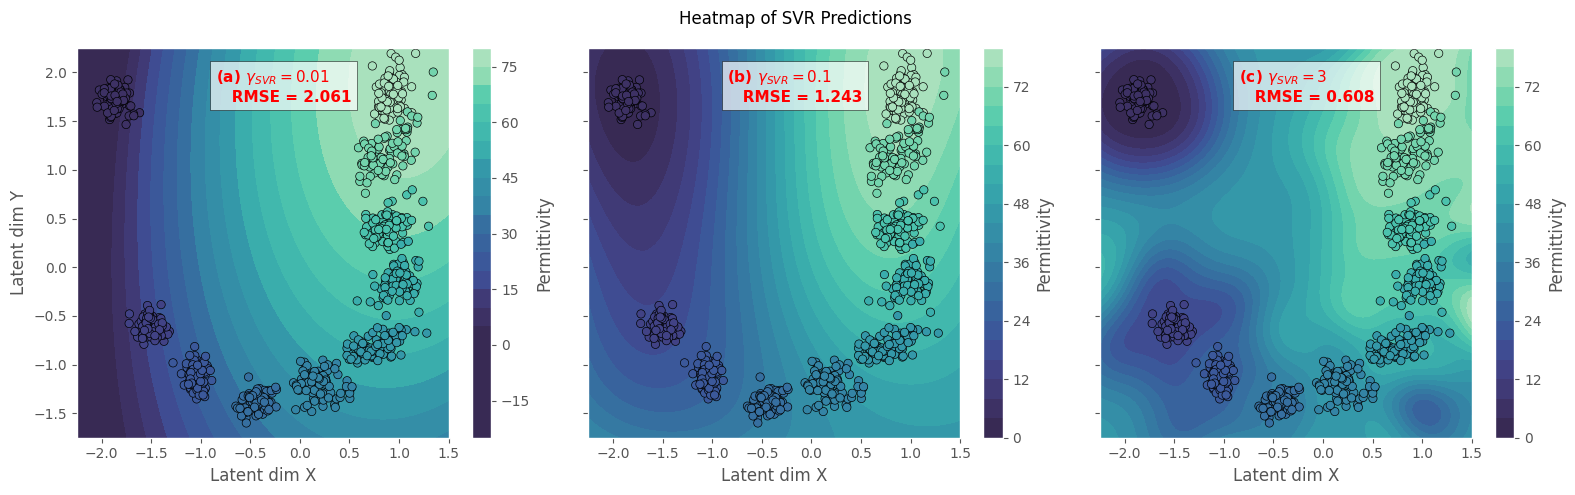

In [ ]:
# Load latent encoding data employed in the article to replicate the results
df_latent_encodings=joblib.load(r"/content/beta_0.1/df_latent_encoding_beta_0.1.pkl")
latent_avg_points=joblib.load(r"/content/beta_0.1/latent_avg_points_beta_0_1.pkl") # Latent points of
df_latent_search=load_permittivitys(df_latent_encodings.copy()) # Add permittivity values

# Generate a colormap for contour plots
order= ['WATER','GLY10', 'GLY20','GLY30', 'GLY40','GLY50', 'GLY60','GLY70', 'GLY80','AIR']
mako_cmap = sns.color_palette("mako_r", as_cmap=True)
palette_20 = mako_cmap(np.linspace(0.1, 0.8, 20))  # Generate 20 colors from the colormap as contour levels
indices = [0] + list(range(2, 20, 2)) # Select indices for downsampled palette
palette_10 = [palette_20[i] for i in indices]
custom_cmap = ListedColormap(palette_20[::-1])
# Create a palette dictionary with hue labels as keys and color values
palette_dict = {label: palette_10[i] for i, label in enumerate(order)}

# Prepare latent dimensions and permittivity values
latent_dim=2
x_data=df_latent_search[["Latent_"+str(i+1) for i in range(latent_dim)]]
e_value=df_latent_search['formula']

# Split the data into training and testing sets
lx_train, lx_test, ly_train, ly_test = train_test_split(x_data, e_value, test_size=0.3, random_state=42)

fig, axs= plt.subplots(1, 3, figsize=(16, 5), sharey=True, sharex=True)
axs = axs.flatten()

letras = [
    "(a) $\\gamma_{SVR}=0.01$\n   RMSE = ",
    "(b) $\\gamma_{SVR}=0.1$\n   RMSE = ",
    "(c) $\\gamma_{SVR}=3$\n   RMSE = ",
]

# Iterate over gamma values to create the plots
gamma_values=[0.01, 0.1, 3]
for g,i,t in zip(gamma_values,range(len(axs)),letras):
    svr = SVR(kernel='rbf',C=4050,gamma=g) # Initialize SVR with RBF kernel
    svr.fit(lx_train, ly_train) # Train the model
    ly_pred = svr.predict(lx_test) # Predict on test set
    rmse = root_mean_squared_error(ly_test, ly_pred) # Calculate RMSE

    # Generate a grid for predictions
    x_range = np.linspace(-2.25,1.5, 100)
    y_range = np.linspace(-1.75,2.25, 100)
    x_grid, y_grid = np.meshgrid(x_range, y_range)
    xy_grid = np.c_[x_grid.ravel(), y_grid.ravel()]
    # Predict the values for each point in the grid
    predictions = svr.predict(xy_grid)
    predictions = predictions.reshape(x_grid.shape) # Reshape predictions for heatmap

    # Plot the contour and scatter points
    contour=axs[i].contourf(x_grid, y_grid, predictions, levels=20, cmap=custom_cmap, vmin=1, vmax=80)
    scatter=sns.scatterplot(data=df_latent_search,x='Latent_1', y='Latent_2', hue='label',
                    palette=palette_dict, edgecolor='black', legend=False, ax=axs[i])

    # Add a colorbar to the subplot
    fig.colorbar(contour, ax=axs[i],label='Permittivity')
    axs[i].set_xlabel('Latent dim X', fontsize=12)
    axs[i].set_xlim(-2.25,1.5)
    axs[i].set_ylim(-1.75,2.25)

    # Annotate the plot with RMSE
    t=t+str(round(rmse,3))
    axs[i].text(-0.85, 1.7, t, fontsize=11, color='red',fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

# Set shared y-axis label and title
axs[0].set_ylabel("Latent dim Y", fontsize=12)
plt.suptitle('Heatmap of SVR Predictions')
plt.tight_layout()
plt.show()

# **Manual latent space search**

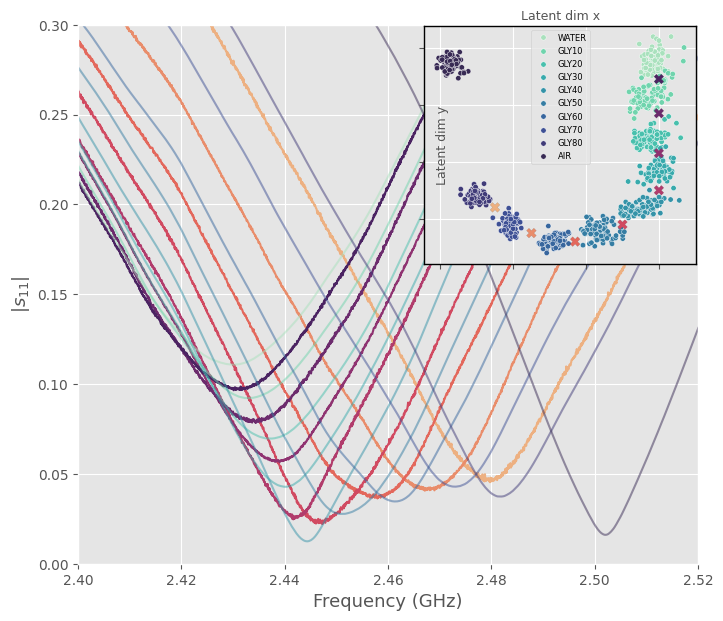

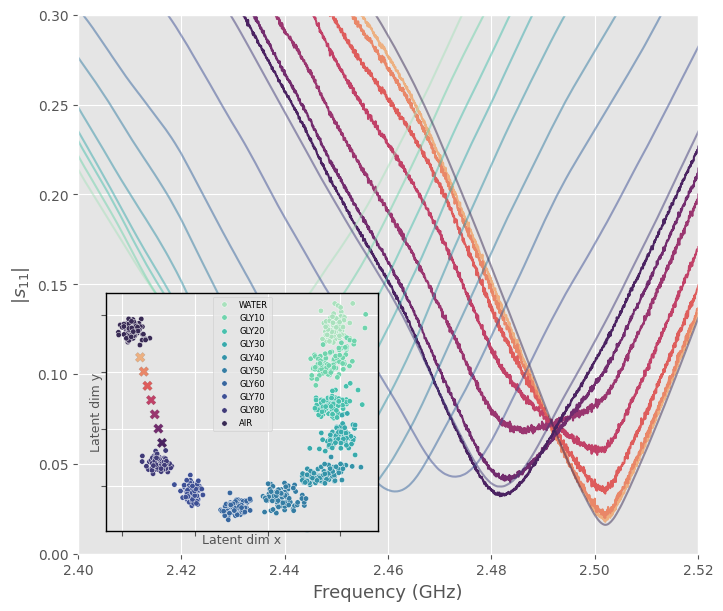

In [ ]:
folder="beta_0.1"
# Load pre-trained weights and additional latent space data
loaded_weights = joblib.load(f'/content/{folder}/weights_{folder}.pkl')
variational_autoencoder.set_weights(weights=loaded_weights)
# Load latent encoding data employed in the article to replicate the results
df_latent_encodings=joblib.load(r"/content/beta_0.1/df_latent_encoding_beta_0.1.pkl")
latent_avg_points=joblib.load(r"/content/beta_0.1/latent_avg_points_beta_0_1.pkl")

# Create a colormap and corresponding palette dictionary for class visualization
mako_cmap = sns.color_palette("mako_r", as_cmap=True)
palette = mako_cmap(np.linspace(0.1, 0.8, 10))
palette_dict = {label: palette[i] for i, label in enumerate(order)} # Create a palette dictionary with hue labels as keys and color values

###### MANUAL SEARCH #########
# Define latent space coordinates for synthetic signal generation
df_generation_classes=pd.DataFrame(data=[[-1.25,-0.8], [-0.75,-1.25],[-0.15,-1.4],[0.5,-1.1],[1,-0.5],[1,0.15],[1,0.85],
                                         [1,1.45],])
df_generation_air=pd.DataFrame(data=[[-1.75,1.25], [-1.7,1],[-1.65,0.75],[-1.6,0.5],[-1.55,0.25],[-1.5,0],[-1.45,-0.25]])

# Loop to generate and visualize synthetic signals for both interpolation cases
for i in range(2):
  # Interpolation between glycerin concentrations
  if i==0:
    df_generation=df_generation_classes.copy()
    fig, ax_gen = plt.subplots(figsize=(8, 7))
    inset_ax = fig.add_axes([0.558, 0.5385, 0.34, 0.34])
    inset_ax.set_xlabel('Latent dim x', labelpad=-190, fontsize=9)
    inset_ax.set_ylabel('Latent dim y', labelpad=-25, fontsize=9)

  # Interpolation between air-GLY80
  else:
    df_generation=df_generation_air.copy()
    fig, ax_gen = plt.subplots(figsize=(8, 7))
    inset_ax = fig.add_axes([0.16, 0.143, 0.34, 0.34])
    inset_ax.set_xlabel('Latent dim x', labelpad=-5, fontsize=9)
    inset_ax.set_ylabel('Latent dim y', labelpad=-5, fontsize=9)

  # Generate labels for latent points to update DataFrame
  gen_labels = [f"[$l_{{x}}={row[0]}$, $l_{{y}}={row[1]}$]" for row in df_generation.values]
  df_generation.columns = lx_train.columns  # Match latent space dimensions
  df_generation['label'] = gen_labels  # Assign labels to each latent point

  # Create colormap and palette for generated signals
  gen_cmap=sns.color_palette("flare", as_cmap=True)
  gen_palette = gen_cmap(np.linspace(0, 1, len(df_generation)))
  gen_palette_dict = {g_label: gen_palette[i] for i, g_label in enumerate(gen_labels)}

  # Decode synthetic signals from latent space and prepare for plotting
  new_spectrum=variational_decoder(df_generation.drop(columns='label'))
  new_spectrum = pd.DataFrame(new_spectrum)
  new_spectrum.columns = average_signals.transpose().columns  # Set proper column names
  new_spectrum = new_spectrum.transpose()  # Transpose for plotting
  new_spectrum.columns = gen_labels  # Assign labels to columns

  # Plot synthetic signals
  for i, column in enumerate(new_spectrum.columns):
      ax_gen.plot(new_spectrum.index, new_spectrum[column], color=gen_palette[i], alpha=1)
  # Overlay original average signals with lower opacity as reference
  for i, column in enumerate(average_signals.columns):
      ax_gen.plot(average_signals.index, average_signals[column], color=palette[i], alpha=0.5)

  ax_gen.set_xlim(2.4,2.52)
  ax_gen.set_ylim(0,0.3)
  ax_gen.set_xlabel('Frequency (GHz)', fontsize=13)
  ax_gen.set_ylabel("|$s_{11}$|", fontsize=13)

   ########## PLOT LATENT SPACE (INSET) ###########
  # Visualize latent encodings and generation points
  sns.scatterplot(data=df_latent_encodings,x='Latent_1', y='Latent_2', hue='label', s=15,
                  palette=palette_dict, ax=inset_ax)
  sns.scatterplot(data=df_generation,x='Latent_1',y='Latent_2', marker='X', s=50, linewidth=0.05,
                      ax=inset_ax,hue='label', edgecolor='black', palette=gen_palette_dict, legend=[])

  # Configure inset aesthetics
  inset_ax.set_xticklabels([])
  inset_ax.set_yticklabels([])
  inset_ax.legend(fontsize=6)
  for spine in inset_ax.spines.values():
      spine.set_color('black')
      spine.set_linewidth(1)

  plt.show()

# **Bayesian latent space search**

#### **Install the GPyOpt library for Bayesian optimization**

In [ ]:
# Install the GPyOpt library for Bayesian optimization
!pip install GPyOpt
import GPyOpt
# Import the bisect module for binary search operations
import bisect

# Function to find the two closest average points to the target value
def get_closest_avg_points(target, df):
    df_sorted = df.sort_values('formula').reset_index(drop=True)
    # Extract sorted values and their corresponding index
    sorted_values = df_sorted['formula']
    sorted_index = df_sorted.index
    # Find insertion point for the search value using bisect
    insert_pos = bisect.bisect_left(sorted_values, target)
    # Determine the indices of the two closest rows
    if insert_pos == 0: #first row
        closest_indices = [sorted_index[0], sorted_index[1]]
    elif insert_pos == len(sorted_values): #last row
        closest_indices = [sorted_index[-2], sorted_index[-1]]
    else:
        closest_indices = [sorted_index[insert_pos - 1], sorted_index[insert_pos]]
    # Retrieve the rows from the original DataFrame
    closest_rows = df_sorted.loc[closest_indices]
    return closest_rows

# Load pre-trained weights, losses, and data for the model
folder="beta_0.1"
loaded_weights = joblib.load(f'/content/{folder}/weights_{folder}.pkl')
variational_autoencoder.set_weights(weights=loaded_weights)
# Load latent encodings and latent averages points
# Load latent encoding data employed in the article to replicate the results
df_latent_encodings=joblib.load(r"/content/beta_0.1/df_latent_encoding_beta_0.1.pkl")
latent_avg_points=joblib.load(r"/content/beta_0.1/latent_avg_points_beta_0_1.pkl") # Latent points of average signals
latent_avg_points['formula']=[78.2998, 75.5077, 70.9935,64.5400,56.2274, 46.5203, 36.2432, 26.4155, 17.9825, 1.0]

# Prepare latent dimensions and permittivity values
latent_dim=2
df_latent_search=load_permittivitys(df_latent_encodings.copy()) # Add permittivity values
x_data=df_latent_search[["Latent_"+str(i+1) for i in range(latent_dim)]]
e_value=df_latent_search['formula']
lx_train, lx_test, ly_train, ly_test = train_test_split(x_data, e_value, test_size=0.3, random_state=42)
# Train a Support Vector Regressor (SVR) model to evaulate the generated latent vector
lx_train, lx_test, ly_train, ly_test = train_test_split(x_data, e_value, test_size=0.3, random_state=42)
svr = SVR(kernel='rbf',C=4050,gamma=3)
svr.fit(lx_train, ly_train)

######## DEFINING SEARCH FUNCTION #######
def interpolador_2D(lat_vec):
    x_lat = lat_vec[:, 0][0] # Extract X-coordinate
    y_lat = lat_vec[:, 1][0] # Extract Y-coordinate
    lat_test=pd.DataFrame(data=[x_lat, y_lat]).transpose() # Create a DataFrame for testing
    lat_test.columns=lx_train.columns

    # Decode latent space to generate spectrum
    test_spectrum=variational_decoder(lat_test)
    # Compute mean squared error for the two closest spectra
    mse1=np.array(keras.losses.mse(closest_spectrums[0], test_spectrum))
    mse2=np.array(keras.losses.mse(closest_spectrums[1], test_spectrum))

    # Predict the target value using the SVR model
    prediction = svr.predict(lat_test)

    # Weight MSE contributions inversely proportional to distance from the target
    scale_factor=1000000
    p_lower=scale_factor/(1+abs(target-e_closest_rows[0])**2)
    p_higher=scale_factor/(1+abs(target-e_closest_rows[1])**2)

    search_error=abs(prediction-target)+p_lower*mse1+p_higher*mse2

    return search_error


#### **Selecting labels and their respective target permittivity values**

Value of (x,y) that minimises the objective:[0.9388358  1.66396184]
Minimum value of the objective: 19.336683167741
78.2998
Value of (x,y) that minimises the objective:[0.84616672 1.24377342]
Minimum value of the objective: 16.493113106308044
75.5077
Value of (x,y) that minimises the objective:[0.81086   0.6531691]
Minimum value of the objective: 23.8160848267937
70.9935
Value of (x,y) that minimises the objective:[ 0.93832944 -0.10677072]
Minimum value of the objective: 8.278455457423348
64.54
Value of (x,y) that minimises the objective:[ 1.34549224 -1.59868693]
Minimum value of the objective: 88.98708592115942
56.2274
Value of (x,y) that minimises the objective:[ 0.24453373 -1.19884666]
Minimum value of the objective: 12.063738314858853
46.5203
Value of (x,y) that minimises the objective:[-0.45760319 -1.59868693]
Minimum value of the objective: 29.8520433517118
36.2432
Value of (x,y) that minimises the objective:[-1.09080673 -1.13895687]
Minimum value of the objective: 26.11487649238

NameError: name 'ticker' is not defined

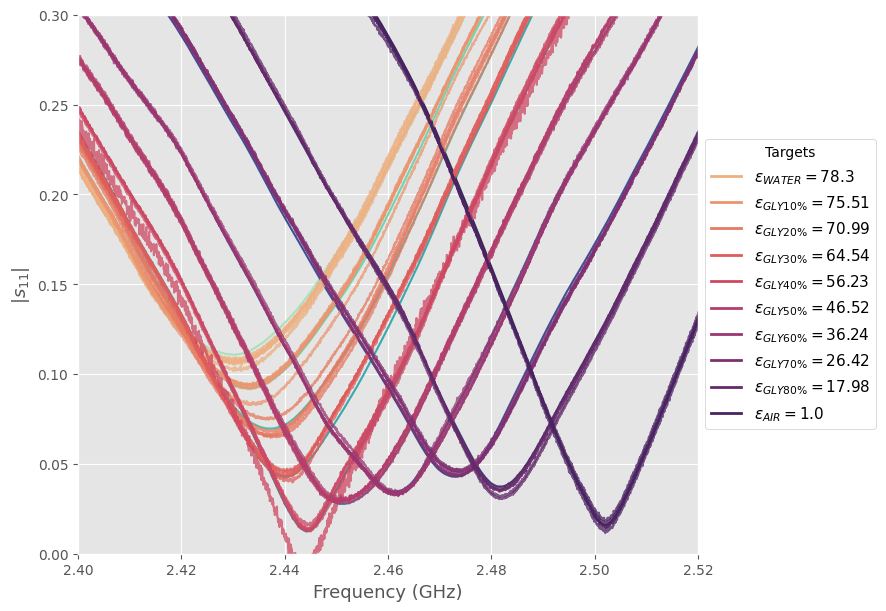

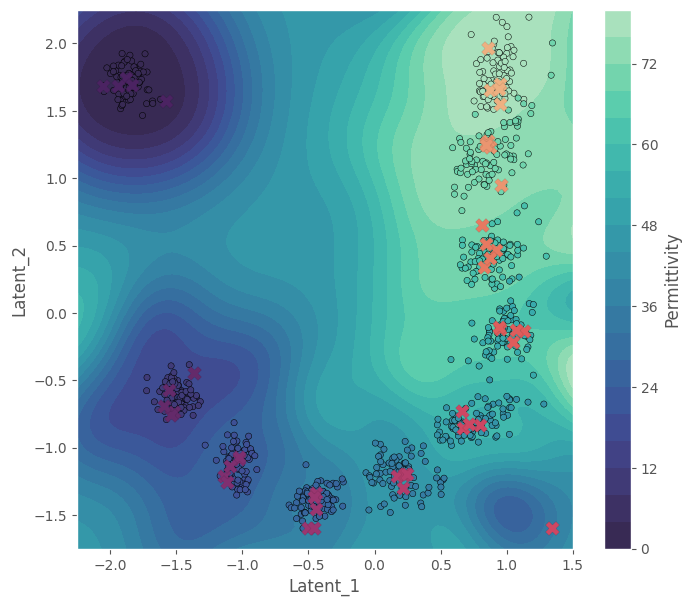

In [ ]:
## TARGETS FOR INTERPOLATION ##
targets_labels=["GLY75\%","GLY65\%","GLY55\%","GLY45\%","GLY35\%","GLY25\%","GLY15\%","GLY05\%"]
targets=       [21.9764  , 31.2089 , 41.3910 , 51.5038 , 60.5964 , 68.0125 , 73.4849 , 77.0975]

## TARGETS FOR ORIGINAL CLASSES ##
# targets_labels=["WATER","GLY10\%","GLY20\%","GLY30\%","GLY40\%","GLY50\%","GLY60\%","GLY70\%","GLY80\%","AIR"]
# targets=latent_avg_points['formula']

# Define bounds for the search in latent space
x_lim_a=min(lx_train['Latent_1'])
x_lim_b=max(lx_train['Latent_1'])
y_lim_a=min(lx_train['Latent_2'])
y_lim_b=max(lx_train['Latent_2'])
bounds2d = [{'name': 'var_1', 'type': 'continuous', 'domain': (x_lim_a,x_lim_b)},
            {'name': 'var_2', 'type': 'continuous', 'domain': (y_lim_a,y_lim_b)}]

###### PLOT REFERENCES #####
# Create a colormap for visualizing data
mako_cmap = sns.color_palette("mako_r", as_cmap=True)
palette_mako = mako_cmap(np.linspace(0.1, 0.8, 10))  # Generate 10 colors from the colormap
palette_dict = {label: palette[i] for i, label in enumerate(order)}
# Plot original average signals as reference
fig1, ax1=plt.subplots(figsize=(8, 7))
for i, column in enumerate(average_signals.columns):
    ax1.plot(average_signals.index, average_signals[column], color=palette_mako[i], alpha=1)
# Plot SVR heatmap average signals as reference
fig2, ax2=plt.subplots(figsize=(8, 7))
x_range = np.linspace(-2.25,1.5, 100)
y_range = np.linspace(-1.75,2.25, 100)
# Create a grid of points
x_grid, y_grid = np.meshgrid(x_range, y_range)
xy_grid = np.c_[x_grid.ravel(), y_grid.ravel()]
# Predict the values for each point in the grid
predictions = svr.predict(xy_grid)
predictions = predictions.reshape(x_grid.shape)
# Plot the heatmap
contour=ax2.contourf(x_grid, y_grid, predictions, levels=20, cmap=custom_cmap, vmin=1, vmax=80)
sns.scatterplot(data=df_latent_search,x='Latent_1', y='Latent_2', hue='label', s=20,
                palette=palette_dict, edgecolor='black', legend=False, ax=ax2)

###### GENERATE DESIRED LATENTS #####
# Define a new colormap for the generate samples
gen_cmap=sns.color_palette("flare", as_cmap=True)
gen_palette = gen_cmap(np.linspace(0, 1, len(targets)))
# Initialize lists to store legend elements for signals and latent points
legend_elements=[]
legend_points=[]
# Loop through each target value, its corresponding color, and its label
for target,cc, t_labels in zip(targets,gen_palette, targets_labels):
  # Identify the closest points in the latent space to the target
  closest_rows=get_closest_avg_points(target=target, df=latent_avg_points)
  e_closest_rows=list(closest_rows['formula'])
  closest_rows=closest_rows.drop(columns=['label','formula'])
  # Decode the latent points: the average signals of the closest classes
  closest_spectrums=variational_decoder(closest_rows)

  n_gen=5 # Number of latent points to generate
  generated_encodings=[]
  # Perform Bayesian optimization to find latent points that minimize the objective function
  for i in range(n_gen):
    myBopt_2d = GPyOpt.methods.BayesianOptimization(interpolador_2D, domain=bounds2d)
    myBopt_2d.run_optimization(max_iter = 25) # Perform 25 iterations of optimization
    generated_encodings.append(myBopt_2d.x_opt) # Append the encoding found to the list

  # Print optimization results
  print("="*20)
  print("Value of (x,y) that minimises the objective:"+str(myBopt_2d.x_opt))
  print("Minimum value of the objective: "+str(myBopt_2d.fx_opt))
  print("="*20)

  ########### GENERADOR ###########
  # Decode the newly generated latent points into signal space
  lat_test_codins=tf.constant(generated_encodings)
  new_spectrum=variational_decoder(lat_test_codins)
  new_spectrum=pd.DataFrame(new_spectrum)
  new_spectrum.columns=average_signals.transpose().columns

  ########### PLOT GEN SIGNAL ###########
  ax1.plot(new_spectrum.transpose(),color=cc, alpha=0.75)
  # Add the generated signal to the legend
  legend_elements.append(Line2D([0], [0], color=cc, lw=2, label=r"$\varepsilon_{" + f"{t_labels}"+"}=" + str(round(target,2))+r'$'))
  # Add generated latent points to a separate legend
  legend_points.append(Line2D([0], [0], marker='X', color=cc,  label=r"$\varepsilon_{" + f"{t_labels}"+"}=" + str(round(target,2))+r'$',
                  markersize=14, linestyle='None',markerfacecolor=cc))

  ########### PLOT GEN LATENT ###########
  # Extract x and y coordinates from generated latent points
  points_array = np.array(generated_encodings)
  x_gen = points_array[:, 0]
  y_gen = points_array[:, 1]
  lat_gen=pd.DataFrame(data=[x_gen, y_gen]).transpose()
  lat_gen.columns=lx_train.columns
  # Plot the generated latent points on the latent space graph
  sns.scatterplot(data=lat_gen,x='Latent_1',y='Latent_2', marker='X', s=100, linewidth=0.05,
                  edgecolor='black', color=cc, ax=ax2)
  print(f"{target}")

# Create a legend for the generated signals
ax1.legend(handles=legend_elements, fontsize=11,framealpha=1, frameon=True, facecolor='white', ncol=1,
           loc='right', bbox_to_anchor=(1.3, 0.5), title='Targets')
ax1.set_xlim(2.4,2.52)
ax1.set_ylim(0,0.3)
ax1.set_xlabel('Frequency (GHz)', fontsize=13)
ax1.set_ylabel("|$s_{11}$|", fontsize=13)

# Add a colorbar to the latent space plot
cbar = fig.colorbar(contour, ax=ax2,label='Permittivity')
cbar.locator = ticker.MaxNLocator(nbins=21)  # Set the number of ticks on the colorbar
cbar.update_ticks()

# Add a legend for the latent points
ax2.legend(handles=legend_points, fontsize=11,framealpha=1, frameon=True, facecolor='white', ncol=1,
           loc='center left', bbox_to_anchor=(-0.525, 0.5), title='Targets')

# Configure the latent space plot
ax2.set_xlabel('Latent dim X', fontsize=12)
ax2.set_ylabel('Latent dim Y', fontsize=12)
ax2.set_xlim(-2.25,1.5)
ax2.set_ylim(-1.75,2.25)

# **Retraining the model**

In [ ]:
!pip install tensorflow==2.15 ### The article worked with this version of tf to train the model
#### LOAD DATA #####
# Load VNA (Vector Network Analyzer) dataset for GLY measurements
DataSET_VNA = joblib.load(r'/content/VNA_GLY.pkl')  # Load dataset with signal data and labels
labels = DataSET_VNA['label']  # Extract labels from the dataset
DataSET_VNA = DataSET_VNA.drop(columns='label')  # Remove label column to keep only signal data
columns_names = DataSET_VNA.columns  # Store column names for future reference
n_signals, n_columns = DataSET_VNA.shape  # Determine the dimensions of the dataset
X_train, X_val, y_train, y_val= train_test_split(DataSET_VNA,labels, test_size=0.15)

##### VAE ARCHITECTURE #####
# Define a custom layer for the sampling step in the Variational Autoencoder (VAE)
class Sampling(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = tf.random.set_seed(1337)
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Dimensionality of the latent space
latent_dim =2
#### ENCODER ####
original_spectrum = keras.Input(shape=[n_columns])
E = layers.BatchNormalization()(original_spectrum)
E = layers.Dense(50, activation="leaky_relu", kernel_initializer='he_normal')(E)
E = layers.BatchNormalization()(E)
E = layers.Dense(50, activation="leaky_relu", kernel_initializer='he_normal')(E)
codings_means=layers.Dense(latent_dim)(E)
codings_log_var=layers.Dense(latent_dim)(E)
codings=Sampling()([codings_means, codings_log_var])
variational_encoder=keras.Model(inputs=original_spectrum,outputs=[codings_means,codings_log_var,codings])
##### DECODER #####
decoder_inputs=keras.Input(shape=[latent_dim])
D = layers.BatchNormalization()(decoder_inputs)
D = layers.Dense(50, activation="leaky_relu", kernel_initializer='he_normal')(D)
D = layers.BatchNormalization()(D)
D = layers.Dense(50, activation="leaky_relu", kernel_initializer='he_normal')(D)
decoder_outputs=layers.Dense(n_columns, activation="linear")(D)
variational_decoder=keras.Model(inputs=[decoder_inputs],outputs=[decoder_outputs])
##### COMPLETE MODEL #####
codings_means,codings_log_var,codings=variational_encoder([original_spectrum])
reconstructions=variational_decoder(codings)
variational_autoencoder=keras.Model(inputs=[original_spectrum],outputs=[reconstructions,codings_means,codings_log_var])
#### VAE LOSS #####
# Define the loss functions for the Variational Autoencoder
# Reconstruction loss: Measures how well the reconstructed signals match the original signals
RE_loss = K.mean(n_columns * keras.losses.mse(original_spectrum, reconstructions))
# KL divergence loss: Encourages the learned latent space to approximate a Gaussian distribution
kl_loss = -0.5 * K.mean(1 + codings_log_var - K.square(codings_means) - K.exp(codings_log_var))
# Beta parameter controls the trade-off between reconstruction and regularization
beta = 0.1
# Total VAE loss is the sum of reconstruction loss and weighted KL divergence loss
vae_loss = RE_loss + beta*kl_loss
variational_autoencoder.add_loss(vae_loss)
# Add metrics to monitor during training
variational_autoencoder.add_metric(RE_loss, name='RE error')
variational_autoencoder.add_metric(beta*kl_loss, name='KL error')
variational_autoencoder.add_metric(codings_log_var, name='log_var')
variational_autoencoder.add_metric(codings_means, name='means')

###### TRAINING #####
# Define the optimizer and training parameters
optimizer=keras.optimizers.Nadam(learning_rate=0.015) # Use Nadam optimizer with a learning rate of 0.015
variational_autoencoder.compile(optimizer=optimizer)
# Define callbacks for better training management
early_stopping_cb=keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
lr_scheduler=keras.callbacks.ReduceLROnPlateau(factor=0.75,patience=10)
# Train the VAE
history = variational_autoencoder.fit(X_train, X_train,epochs=1000, batch_size=64,
                                validation_data=(X_val, X_val),
                                callbacks=[lr_scheduler,early_stopping_cb],
                                verbose=False,
                                )
# Convert training history to a DataFrame for analysis and visualization
df_history=pd.DataFrame(history.history)

fig, axs = plt.subplots(3, 2, figsize=(20, 20))
axs = axs.flatten()
df_history['KL error'].plot(ax=axs[0], title='KL error', grid=True,xlabel='Epoch',style=["black","r--"])
df_history['val_KL error'].plot(ax=axs[0], grid=True,xlabel='Epoch',style=["orange","r--"]); axs[0].legend()


df_history['RE error'].plot(ax=axs[1], title='RE error', grid=True,xlabel='Epoch',style=["black","r--"])
df_history['val_RE error'].plot(ax=axs[1], grid=True,xlabel='Epoch',style=["orange","r--"]); axs[1].legend()

df_history['loss'].plot(ax=axs[2], title='VAE loss', grid=True,xlabel='Epoch',style=["black","r--"])
df_history['val_loss'].plot(ax=axs[2], grid=True,xlabel='Epoch',style=["orange","r--"]); axs[2].legend()

df_history['log_var'].plot(ax=axs[3], title='Log_Var', grid=True,xlabel='Epoch',style=["black","r--"])
df_history['val_log_var'].plot(ax=axs[3], grid=True,xlabel='Epoch',style=["orange","r--"]); axs[3].legend()

df_history['means'].plot(ax=axs[4], title='Means $\mu$', grid=True,xlabel='Epoch',style=["black","r--"])
df_history['val_means'].plot(ax=axs[4], grid=True,xlabel='Epoch',style=["orange","r--"]); axs[4].legend()

df_history['lr'].plot(ax=axs[5], title='Learning rate', grid=True,xlabel='Epoch',style=["black","r--"]); axs[5].legend()

plt.tight_layout()
plt.show()